# 01 - Building & Training Convolutional Neural Net Models via *Google Colab*

The below workflow consists of code I wrote in Google Colab to do 4 things:
1. Read and preprocess image data
2. Build & Train CNN Models
3. Evaluate Model performance
4. Repeat steps 2-3 via transfer learning (**Xception** & **VGG16**)

I utilized Colab's A100 GPU to train my models due to time limitations. Due to fixed hardware restrictions from my own tech availabilities and runtime limitations on Google Colab, I was unable to build my models further. However, I did train 3 separate models with the resources I had access to and achieved a maximum 95% prediction accuracy across 4 image classes. <br>

Below you will find both my code, and explanations along the way, as I attempt to build models that can accurately process MRI scans of brains and assess the type of tumor present. All images present consist of 4 possibilities: no tumor, meningioma, glioma, and pituitary.

## 1. Imports

In [30]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# os & image imports
import os
from PIL import Image

# tensorflow
import tensorflow as tf

# keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, SpecificityAtSensitivity, SensitivityAtSpecificity

# sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split # need this to split the train set into train/test for model training

To read the data in and also store the labels, I am going to make dataframes by iterating through the contents of the `archive` folder under the `data` directory. Each images are further split into `Testing` and `Training` folders, each with separate directories for images corresponding to the type of tumor: Glioma, Meningioma, Pituitary, No Tumor.

In [7]:
# Colab directories (different from my local directories)
# test_directory = '/content/drive/MyDrive/data/archive/Testing'
# train_directory = '/content/drive/MyDrive/data/archive/Training'

test_directory = './data/archive/Testing'
train_directory = './data/archive/Training'

---
## 2. Examining Data & Brief EDA

In [8]:
def image_to_df(filepath):

    base = os.listdir(filepath)
    base.remove('.DS_Store') # removes this element from the list, remaining should be the actual folders

    label = []
    img_path = []
    folder_path = []

    for folder_name in base:
        images = os.listdir(filepath + f'/{folder_name}')
        for i in images:
            if i.endswith(".jpg"):
                label.append(folder_name)
                img_path.append(f'{filepath}/{folder_name}/{i}')
                folder_path.append(f'{filepath}/{folder_name}')

    return pd.DataFrame(data={'folder_path': folder_path,'img_path': img_path, 'label': label})

In [9]:
# storing the output of the function for test data
test_df = image_to_df(test_directory)

In [10]:
# storing the output of the function for train data
train_df = image_to_df(train_directory)

In [11]:
test_df.head()

,folder_path,img_path,label
0,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0233.jpg,pituitary
1,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0227.jpg,pituitary
2,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0019.jpg,pituitary
3,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0031.jpg,pituitary
4,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0025.jpg,pituitary


In [12]:
train_df.head()

,folder_path,img_path,label
0,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0505.jpg,pituitary
1,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0263.jpg,pituitary
2,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0277.jpg,pituitary
3,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_1169.jpg,pituitary
4,./data/archive/Training/pituitary,./data/archive/Training/pituitary/Tr-pi_0511.jpg,pituitary


Organizing the training and testing datasets into dataframes like above helps me properly see both the filepaths and assigns labels that will correspond to each picture. This will help us quickly preprocess the images when we pass the dataframes through `ImageDataGenerator`'s `.flow_from_dataframe()` function later down the road. <br> 

Finally, let's further divide the train dataframe into a train **and** validation dataframe. We will have to create a validation dataset to feed into our models for training purposes later down the road as well. Since neural networks thrive with bountiful data, I will only split off 20% for validation purposes and leave the remaining 80% for training the model.

In [13]:
# train/test split
train_df, val_df = train_test_split(train_df, test_size = 0.20, train_size = 0.80, stratify = train_df['label'])

### **2a. Brief EDA on our Image Sets**
Let's quickly look to see class proportions in the dataset.

In [14]:
round(train_df['label'].value_counts(normalize = True), 2)

label
notumor       0.28
pituitary     0.25
meningioma    0.23
glioma        0.23
Name: proportion, dtype: float64

In [15]:
print('This should be very roughly the same as the train_df')
round(val_df['label'].value_counts(normalize = True), 2)

This should be very roughly the same as the train_df


label
notumor       0.28
pituitary     0.26
meningioma    0.23
glioma        0.23
Name: proportion, dtype: float64

In [16]:
round(test_df['label'].value_counts(normalize = True), 2)

label
notumor       0.31
meningioma    0.23
pituitary     0.23
glioma        0.23
Name: proportion, dtype: float64

In [17]:
print(f'Images in Training across all 4 classes: {len(train_df)}')
print("===============================================")
print(f'Images in Validation across all 4 classes: {len(val_df)}')
print("===============================================")
print(f'Images in Testing across all 4 classes: {len(test_df)}')

Images in Training across all 4 classes: 4569
Images in Validation across all 4 classes: 1143
Images in Testing across all 4 classes: 1311


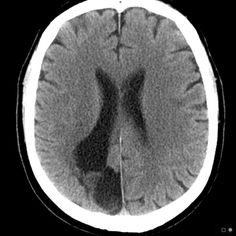

In [22]:
# let's take a look at some image samples
Image.open(train_df.iloc[0,1])

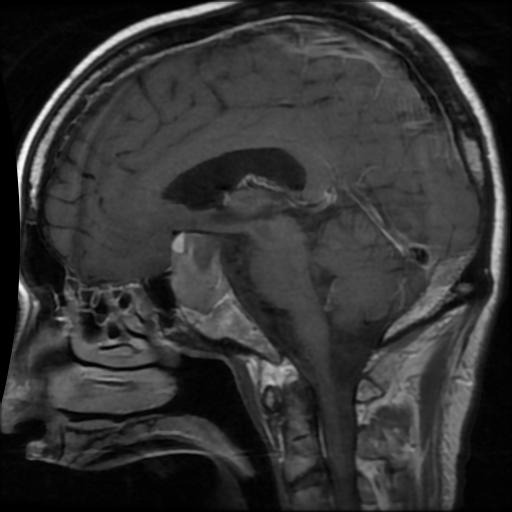

In [21]:
Image.open(train_df.iloc[500,1])

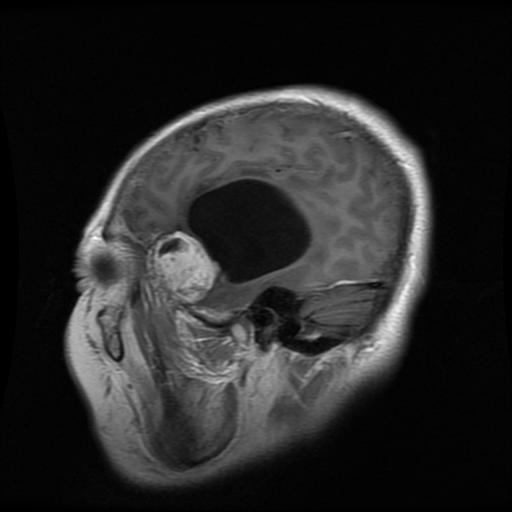

In [24]:
Image.open(train_df.iloc[125,1])

From exploring the above two samples, it's immediately clear that we will very much need to preprocess our image data. Both pictures above are different sizes and consist of varying hues of brightness. Additionally, some of the images contain more padding around the corners than others. Most pictures also contain different views of the brain, such as saggital, axial, or coronal. Therefore, exploring the images above helps us better understand what kind of preprocessing will be necessary on our images. <br>

Below is some additional EDA so we can better understand the class distribution.

In [60]:
# train and validation have roughly the same proportions --> stratified

class_counts = pd.DataFrame({'train': round(train_df['label'].value_counts(normalize = True), 2), 
                             'test': round(test_df['label'].value_counts(normalize = True), 2)})

class_counts

,train,test
label,,
glioma,0.23,0.23
meningioma,0.23,0.23
notumor,0.28,0.31
pituitary,0.25,0.23


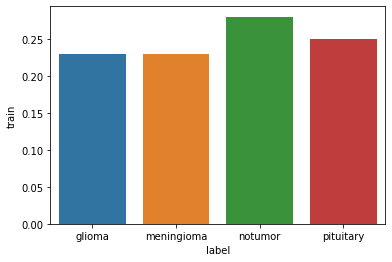

In [70]:
sns.barplot(data = class_counts, x = class_counts.index, y = 'train');

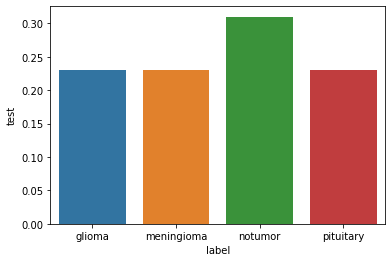

In [71]:
sns.barplot(data = class_counts, x = class_counts.index, y = 'test');

Overall, both the training and testing datasets have roughly similar composition in terms of class proportions. The test dataset, however, does seem to have a slightly higher portion of `notumor` images, but since there are far greater images overall in the training set, this should not be too much of an issue for the model.

---
## 3. Preprocessing with `ImageDataGenerator()`

After exploring briefly exploring the image data, we can move onto the preprocessing section. Below, I will instantiate `ImageDataGenerator()` for training, validation, and testing separately. I will keep the testing one very basic, and only rescale the images. For testing and training, however, I'll add a brightness_range feature to create varying images that are sligthly darker, and slightly lighter. Part of the reason for this is to help counter overfitting by improving the generalizability of the model. As we saw in the EDA portion, some of the images may be slightly darker or lighter, so exposing the model to varying degrees of brightness may help it learn better.

In [72]:
# instantiate ImageDataGenerator Class (called 'idg') for train and val
idg_train = ImageDataGenerator(rescale = 1./255,
                               brightness_range=(0.6, 1.4),)

idg_val = ImageDataGenerator(rescale = 1./255,
                             brightness_range=(0.6, 1.4),)


# keep testing separate
idg_test = ImageDataGenerator(rescale = 1./255,)

Now I can use the `.flow_from_dataframe()` function associated with the instantiated classes and quickly preprocess the images using the dataframes we made before. <br> 
Preprocessing techniques:
1. Encoding our classes as categorical variables (0, 1, 2, 3 representation)
2. Fixing a set size for **ALL** images (256 x 256)
3. Converting all images to "color" (RGB) - this is primarily necessary for the pretrained models I'll use later
4. Batch size - Number of images to sample for each batch

#### **1. Training Data Generator**

In [74]:
train_data_gen = idg_train.flow_from_dataframe(train_df,
                             x_col = 'img_path',
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 4569 validated image filenames belonging to 4 classes.


#### **2. Validation Data Generator**

In [75]:
# the set up here should be the same as 'train_data_gen'
val_data_gen = idg_val.flow_from_dataframe(val_df,
                             x_col = 'img_path',
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             shuffle = False,
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 1143 validated image filenames belonging to 4 classes.


#### **3. Testing Data Generator**

In [76]:
test_data_gen = idg_test.flow_from_dataframe(test_df,
                             x_col = 'img_path',
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             shuffle = False,
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 1311 validated image filenames belonging to 4 classes.


In [77]:
print(train_data_gen.image_shape)
print(val_data_gen.image_shape)
print(test_data_gen.image_shape)

# this is accurate (256x256 size) and 3 for the channel (RGB)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


---
## 4. Building a Basic Model

We can now move to the modeling. As described briefly in the beginning, I am primarily keeping my model architecture as basic as possible due to hardware and time restrictions. CNNs take a lot of computing power and time to run. Since both commodities are scarce, I will keep my network topography basic for now. Instead, I've elected to create 2 additional models to try and improve performance metrics. <br>

For the first model, I will create a Sequential model with 2 blocks of a Conv2D and MaxPooling layer each. Afterwards, I'll flatten the output to convert the arrays into one dimension. Finally, the output layer will be a dense layer that has 4 outputs (1 for each class) and a `softmax` activation. I want the model to predict the probability of an input belonging to each of the 4 classes, and this is what `softmax` will achieve. <br>

Additionally, only 10 epochs will be run due to time limitations.

In [98]:
# instantiating Sequential model, 'model_1'
model_1 = Sequential()

# layer 1
model_1.add(Conv2D(32, 3, activation = "relu", input_shape = (256, 256, 3))) # input shape is 256 x 256, 1 channel
model_1.add(MaxPooling2D(pool_size = 2))

# layer 2
model_1.add(Conv2D(64, 3, activation = "relu",)) # NOTE: no need for an additional input shape here, only needed for the first blocj
model_1.add(MaxPooling2D(pool_size = 2))

# flatten
model_1.add(Flatten())

# output layer
model_1.add(Dense(4, activation = 'softmax')) # we want 4 outputs (4 classes) and 'softmax' activation to give us the probability

# let's view a summary of model_1
print(f"Model Summary:")
print("="*20)
print(model_1.summary())

# compiling the model
model_1.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy', # need categorical_crossentropy since multiclass classification
               metrics = ['accuracy', Precision(), Recall()])

Model Summary:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 246016)            0         
                                                                 
 dense_6 (Dense)             (None, 4) 

In [99]:
# fitting the model to training data
history_1 = model_1.fit(train_data_gen, epochs = 10, validation_data = val_data_gen, shuffle = False)

Epoch 1/10
126/126 [==============================] - 29s 222ms/step - loss: 0.8679 - accuracy: 0.7061 - precision_4: 0.7719 - recall_4: 0.6075 - val_loss: 0.4956 - val_accuracy: 0.8136 - val_precision_4: 0.8354 - val_recall_4: 0.7921
Epoch 2/10
126/126 [==============================] - 28s 223ms/step - loss: 0.3219 - accuracy: 0.8866 - precision_4: 0.9010 - recall_4: 0.8749 - val_loss: 0.7166 - val_accuracy: 0.7373 - val_precision_4: 0.7430 - val_recall_4: 0.7309
Epoch 3/10
126/126 [==============================] - 29s 227ms/step - loss: 0.1651 - accuracy: 0.9423 - precision_4: 0.9469 - recall_4: 0.9388 - val_loss: 0.4020 - val_accuracy: 0.8882 - val_precision_4: 0.8935 - val_recall_4: 0.8847
Epoch 4/10
126/126 [==============================] - 29s 230ms/step - loss: 0.0765 - accuracy: 0.9743 - precision_4: 0.9764 - recall_4: 0.9725 - val_loss: 0.3914 - val_accuracy: 0.8923 - val_precision_4: 0.8944 - val_recall_4: 0.8882
Epoch 5/10
126/126 [==============================] - 28s 22

### **4a. Evaluating Model 1**

In [100]:
# the .history attribute outputs a dictionary of the metrics over each epoch the model ran for both training and validation sets
history_1.history

{'loss': [0.8678580522537231,
  0.32191193103790283,
  0.16514720022678375,
  0.0765305906534195,
  0.03703060373663902,
  0.04187095910310745,
  0.018943021073937416,
  0.015179683454334736,
  0.011409950442612171,
  0.010698865167796612],
 'accuracy': [0.7061173319816589,
  0.8866416811943054,
  0.9423220753669739,
  0.9742821455001831,
  0.9887640476226807,
  0.9902621507644653,
  0.9945068955421448,
  0.9960049986839294,
  0.9970037341117859,
  0.9967540502548218],
 'precision_4': [0.7718908786773682,
  0.901002824306488,
  0.9468647837638855,
  0.9764351844787598,
  0.9892473220825195,
  0.9905071258544922,
  0.9945068955421448,
  0.9960049986839294,
  0.9970037341117859,
  0.9967540502548218],
 'recall_4': [0.6074906587600708,
  0.8749063611030579,
  0.9388264417648315,
  0.9725343585014343,
  0.9877653121948242,
  0.9900124669075012,
  0.9945068955421448,
  0.9960049986839294,
  0.9970037341117859,
  0.9967540502548218],
 'val_loss': [0.4955854117870331,
  0.7166063189506531,
  

#### **1. Graphing Training vs. Validation Loss, Accuracy, Precision, & Recall**

In [101]:
history_1.history.keys()

dict_keys(['loss', 'accuracy', 'precision_4', 'recall_4', 'val_loss', 'val_accuracy', 'val_precision_4', 'val_recall_4'])

In [103]:
# let's save the history output in separate lists
train_loss = history_1.history['loss']
train_acc = history_1.history['accuracy']
train_precision = history_1.history['precision_4']
train_recall = history_1.history['recall_4']

val_loss = history_1.history['val_loss']
val_acc = history_1.history['val_accuracy']
val_precision = history_1.history['val_precision_4']
val_recall = history_1.history['val_recall_4']

epochs = [i+1 for i in history_1.epoch] # quick list comprehension since the original epochs list is from 0 - 9

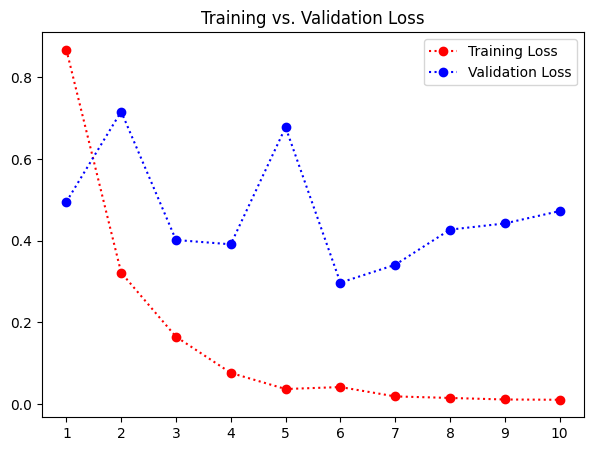

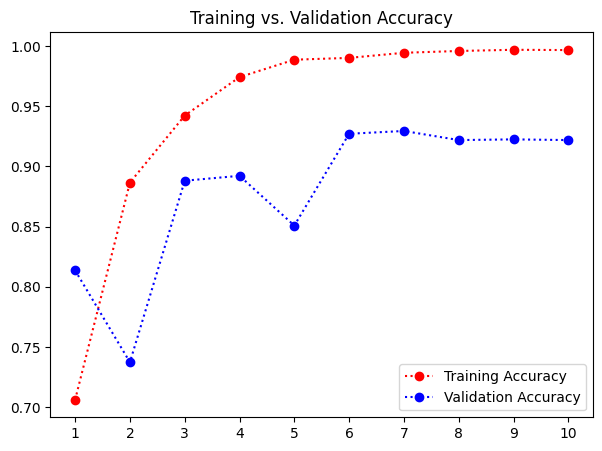

In [104]:
# plotting
plt.figure(figsize = (7,5))
plt.plot(epochs, train_loss, 'o:r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'o:b', label = 'Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.xticks(epochs)
plt.savefig('/content/drive/MyDrive/graphs/train_val_loss.jpeg', dpi = 1080);

# some overfitting, but not extremely overfit
# validation loss ceases to improve after 7th epoch

plt.figure(figsize = (7,5))
plt.plot(epochs, train_acc, 'o:r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'o:b', label = 'Validation Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.xticks(epochs)
plt.savefig('/content/drive/MyDrive/graphs/train_val_accuracy.jpeg', dpi = 1080);

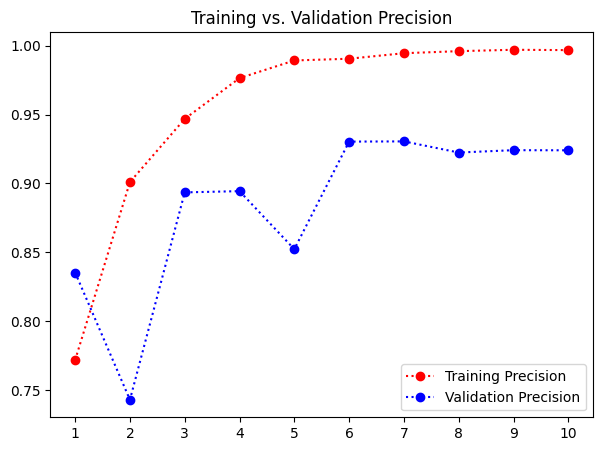

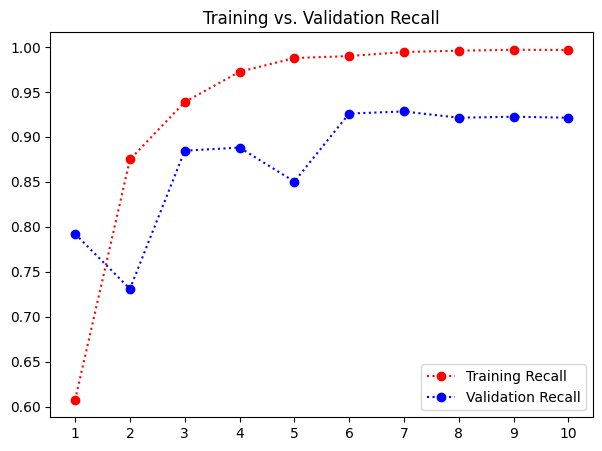

In [105]:
# plotting
plt.figure(figsize = (7,5))
plt.plot(epochs, train_precision, 'o:r', label = 'Training Precision')
plt.plot(epochs, val_precision, 'o:b', label = 'Validation Precision')
plt.legend()
plt.title('Training vs. Validation Precision')
plt.xticks(epochs)
plt.savefig('/content/drive/MyDrive/graphs/train_val_precision.jpeg', dpi = 1080);

# some overfitting, but not extremely overfit
# validation loss ceases to improve after 7th epoch

plt.figure(figsize = (7,5))
plt.plot(epochs, train_recall, 'o:r', label = 'Training Recall')
plt.plot(epochs, val_recall, 'o:b', label = 'Validation Recall')
plt.legend()
plt.title('Training vs. Validation Recall')
plt.xticks(epochs)
plt.savefig('/content/drive/MyDrive/graphs/train_val_recall.jpeg', dpi = 1080);

In [106]:
# let's evaluate the model on the testing dataset now
model_1.evaluate(test_data_gen)

41/41 [==============================] - 5s 117ms/step - loss: 0.4959 - accuracy: 0.9230 - precision_4: 0.9258 - recall_4: 0.9230


[0.49590909481048584, 0.922959566116333, 0.9257842302322388, 0.922959566116333]

Overall, the performance of the model is promising. Despite having only 2 layers and 10 iterations to train, the validation scores are quickly reaching in the high low 90s. Accuracy, precision, and recall all are roughly 92%. <br>
Despite adding measures during preprocessing to reduce overfitting, the model is still suffering from it, particularly noticeable in the 'loss' metric. In the later 2 models, I will add some `Dropout` layers to help further counter this.

#### **2. Generating Predictions & Confusion Matrix**

In [109]:
preds_1_probs = model_1.predict(test_data_gen)

41/41 [==============================] - 5s 118ms/step


In [110]:
preds_1_probs

array([[9.79148924e-01, 2.35918735e-04, 2.06080917e-02, 7.04014246e-06],
       [9.99998689e-01, 6.89646651e-09, 3.32900953e-07, 9.40275640e-07],
       [9.99999762e-01, 2.96603758e-07, 5.49146178e-13, 1.30564270e-25],
       ...,
       [1.31344223e-06, 1.25744432e-01, 8.58982921e-01, 1.52713591e-02],
       [1.87812184e-08, 5.14858039e-06, 9.99994874e-01, 1.74284835e-13],
       [1.15679946e-07, 7.03870819e-06, 9.92808819e-01, 7.18405796e-03]],
      dtype=float32)

In [111]:
preds_1 = np.argmax(preds_1_probs, axis = 1)
preds_1

array([0, 0, 0, ..., 2, 2, 2])

In [112]:
# creating a confusion matrix
conf_matrix = confusion_matrix(test_data_gen.classes, preds_1)

conf_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels = test_data_gen.class_indices)

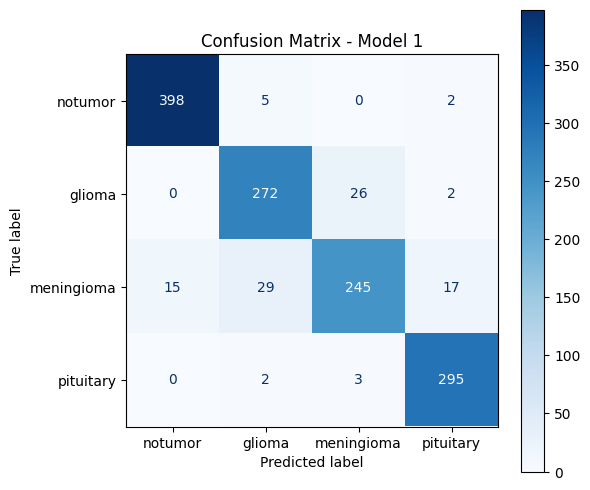

In [113]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Model 1')
plt.savefig('/content/drive/MyDrive/graphs/cm_model1.jpeg', dpi = 1080)
plt.show()

The confusion matrix above shows us the count of each predicted label vs. the actual label. The diagonal represents completely accurate predictions from the model. The darker hue colors help show that the model is performing overall decently despite the simple network architecture.

In [114]:
# overall accuracy
(preds_1 == test_data_gen.classes).mean()

0.9229595728451564

In [117]:
# saving model 1 (in both formats just in case)
model_1.save('/content/drive/MyDrive/cnn_models/model1.h5')
model_1.save('/content/drive/MyDrive/cnn_models/model1.keras')

---
## 5. Building Model 2 via Transfer Learning - Xception

To reiterate, I won't try to make the previous model stronger by adding complexity due to time and hardware limitations. Instead, I will use a pretrained model, and manually adjust for overfitting issues to increase generalizability to help predict the class for our images. Much of the network structure is the same, except for the base layer. I am adding some Dropout layers to help reduce overfitting. Dropout is essentially a regularization technique that sets a portion of our inputs to 0. In this case, I will use 20% for the Dropout hyperparameter.

In [119]:
# instantiate Xception class
pretrained_base = tf.keras.applications.Xception(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3), pooling = 'max')

# instantiating Sequential model, 'model_1'
model_2 = Sequential(pretrained_base)

# flatten
model_2.add(Flatten())
model_2.add(Dropout(0.20))

# adding dense layers
model_2.add(Dense(64, activation = "relu"))
model_2.add(Dropout(0.20))

# output layer
model_2.add(Dense(4, activation = 'softmax')) # we want 4 outputs (4 classes) and 'softmax' activation to give us the probability


# let's view a summary of model_1
print(f"Model Summary:")
print("="*20)
print(model_2.summary())

# compiling the model
model_2.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy', # need categorical_crossentropy since multiclass classification
               metrics = ['accuracy', Precision(), Recall()])

Model Summary:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                131136    
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 4)                 260       
                                                                 
Total params: 20992876 (80.08 MB)
Train

In [120]:
history_2 = model_2.fit(train_data_gen, epochs = 10, validation_data = val_data_gen, shuffle = True)

Epoch 1/10
126/126 [==============================] - 45s 245ms/step - loss: 0.9901 - accuracy: 0.5658 - precision_6: 0.8627 - recall_6: 0.3576 - val_loss: 2.7229 - val_accuracy: 0.5405 - val_precision_6: 0.5412 - val_recall_6: 0.5277
Epoch 2/10
126/126 [==============================] - 29s 233ms/step - loss: 0.2672 - accuracy: 0.9106 - precision_6: 0.9332 - recall_6: 0.8896 - val_loss: 0.9676 - val_accuracy: 0.7886 - val_precision_6: 0.7967 - val_recall_6: 0.7851
Epoch 3/10
126/126 [==============================] - 29s 230ms/step - loss: 0.1799 - accuracy: 0.9491 - precision_6: 0.9599 - recall_6: 0.9391 - val_loss: 2.3980 - val_accuracy: 0.7595 - val_precision_6: 0.7632 - val_recall_6: 0.7566
Epoch 4/10
126/126 [==============================] - 29s 231ms/step - loss: 0.1063 - accuracy: 0.9673 - precision_6: 0.9742 - recall_6: 0.9608 - val_loss: 1.0461 - val_accuracy: 0.8725 - val_precision_6: 0.8745 - val_recall_6: 0.8725
Epoch 5/10
126/126 [==============================] - 29s 22

In [121]:
history_2.history

{'loss': [0.990114688873291,
  0.26724761724472046,
  0.17994564771652222,
  0.10631521046161652,
  0.097648486495018,
  0.10586709529161453,
  0.05108984187245369,
  0.06107957288622856,
  0.050600722432136536,
  0.028767365962266922],
 'accuracy': [0.5657927393913269,
  0.9106117486953735,
  0.9490636587142944,
  0.9672908782958984,
  0.9735330939292908,
  0.974032461643219,
  0.9852684140205383,
  0.9847690463066101,
  0.987265944480896,
  0.9932584166526794],
 'precision_6': [0.8626505732536316,
  0.933211088180542,
  0.9599285125732422,
  0.9741772413253784,
  0.9800000190734863,
  0.9803377985954285,
  0.9869674444198608,
  0.9864423871040344,
  0.9882293939590454,
  0.9939939975738525],
 'recall_6': [0.35755306482315063,
  0.8896379470825195,
  0.9390761256217957,
  0.960798978805542,
  0.9665418267250061,
  0.9710361957550049,
  0.9832708835601807,
  0.9810237288475037,
  0.9852684140205383,
  0.9917603135108948],
 'val_loss': [2.7228927612304688,
  0.9676375985145569,
  2.3979

In [125]:
preds_2_probs = model_2.predict(test_data_gen)

41/41 [==============================] - 5s 126ms/step


In [126]:
preds_2_probs

array([[3.3025246e-02, 2.6659679e-03, 9.6172845e-01, 2.5803798e-03],
       [1.0000000e+00, 3.1575805e-13, 2.9170577e-08, 1.3707164e-09],
       [9.9992311e-01, 9.9848152e-10, 7.6860466e-05, 1.1636492e-08],
       ...,
       [1.0859522e-10, 1.3564924e-09, 1.0000000e+00, 3.7908534e-09],
       [6.1193731e-13, 5.1104093e-14, 1.0000000e+00, 5.6357485e-11],
       [7.4129822e-03, 7.8911401e-02, 8.6961824e-01, 4.4057343e-02]],
      dtype=float32)

In [127]:
preds_2 = np.argmax(preds_2_probs, axis = 1)

In [128]:
# creating a confusion matrix
conf_matrix_2 = confusion_matrix(test_data_gen.classes, preds_2)

conf_matrix_2 = ConfusionMatrixDisplay(conf_matrix_2, display_labels = test_data_gen.class_indices)

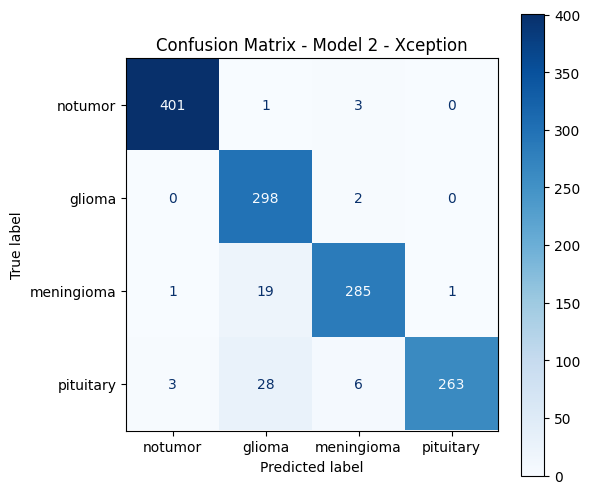

In [129]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix_2.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Model 2 - Xception')
plt.savefig('/content/drive/MyDrive/graphs/cm_model2.jpeg', dpi = 1080)
plt.show()

In [130]:
(preds_2 == test_data_gen.classes).mean()

0.9511823035850496

In [131]:
# saving Xception
model_2.save('/content/drive/MyDrive/cnn_models/model2.h5')
model_2.save('/content/drive/MyDrive/cnn_models/model2.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The Xception model performed very well. Again, the model is lacking in complexity, yet it is yielding strong results to lend support to the fact that CNNs can be extremely useful in predicting disease from images. The overall accuracy from Xception is at 95%.

---
## 6. Building Model 3 via Transfer Learning - VGG16
Finally, I will use the same strategy as above and try another pretrained model, VGG16.

In [132]:
# instantiate VGG16 class
pretrained_base = tf.keras.applications.VGG16(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3), pooling = 'max')

# instantiating Sequential model, 'model_1'
model_3 = Sequential(pretrained_base)

# flatten
model_3.add(Flatten())
model_3.add(Dropout(0.20))

# adding dense layers
model_3.add(Dense(64, activation = "relu"))
model_3.add(Dropout(0.20))

# output layer
model_3.add(Dense(4, activation = 'softmax')) # we want 4 outputs (4 classes) and 'softmax' activation to give us the probability


# let's view a summary of model_1
print(f"Model Summary:")
print("="*20)
print(model_3.summary())

# compiling the model
model_3.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy', # need categorical_crossentropy since multiclass classification
               metrics = ['accuracy', Precision(), Recall()])

58889256/58889256 [==============================] - 0s 0us/step
Model Summary:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 4)                 260       
                                        

In [133]:
history_3 = model_3.fit(train_data_gen, epochs = 10, validation_data = val_data_gen, shuffle = True)

Epoch 1/10
126/126 [==============================] - 40s 245ms/step - loss: 343.5314 - accuracy: 0.2752 - precision_7: 0.3038 - recall_7: 0.0257 - val_loss: 1.2959 - val_accuracy: 0.4613 - val_precision_7: 1.0000 - val_recall_7: 0.0099
Epoch 2/10
126/126 [==============================] - 30s 240ms/step - loss: 1.4829 - accuracy: 0.2839 - precision_7: 0.3492 - recall_7: 0.0257 - val_loss: 1.4138 - val_accuracy: 0.2790 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/10
126/126 [==============================] - 30s 237ms/step - loss: 1.3886 - accuracy: 0.2754 - precision_7: 0.5000 - recall_7: 0.0037 - val_loss: 1.3838 - val_accuracy: 0.2790 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 4/10
126/126 [==============================] - 29s 228ms/step - loss: 1.3903 - accuracy: 0.2754 - precision_7: 0.4146 - recall_7: 0.0042 - val_loss: 1.3578 - val_accuracy: 0.2790 - val_precision_7: 1.0000 - val_recall_7: 0.0012
Epoch 5/10
126/126 [======================

In [134]:
history_3.history

{'loss': [343.5314025878906,
  1.4829306602478027,
  1.38856041431427,
  1.3902605772018433,
  1.2774021625518799,
  1.055414080619812,
  0.9518365263938904,
  0.8728720545768738,
  0.8096310496330261,
  0.7099512815475464],
 'accuracy': [0.27515605092048645,
  0.2838951349258423,
  0.27540573477745056,
  0.27540573477745056,
  0.38926342129707336,
  0.5318351984024048,
  0.5825218558311462,
  0.6289637684822083,
  0.6549313068389893,
  0.7038701772689819],
 'precision_7': [0.30383479595184326,
  0.349152535200119,
  0.5,
  0.4146341383457184,
  0.6949428915977478,
  0.6527554988861084,
  0.6674689054489136,
  0.6958654522895813,
  0.7265780568122864,
  0.7577844262123108],
 'recall_7': [0.025717852637171745,
  0.025717852637171745,
  0.00374531839042902,
  0.004244694020599127,
  0.10636704415082932,
  0.3046192228794098,
  0.4154806435108185,
  0.4958801567554474,
  0.5460674166679382,
  0.6319600343704224],
 'val_loss': [1.2959388494491577,
  1.4138391017913818,
  1.3838475942611694

In [135]:
preds_3_probs = model_3.predict(test_data_gen)

41/41 [==============================] - 6s 151ms/step


In [137]:
preds_3_probs

array([[2.9423556e-01, 2.4578384e-01, 3.4777874e-01, 1.1220187e-01],
       [9.3286848e-01, 1.5503341e-05, 6.1816782e-02, 5.2993246e-03],
       [9.9359590e-01, 4.7051606e-05, 6.3488632e-03, 8.3000732e-06],
       ...,
       [4.0937006e-03, 3.4029767e-01, 6.4593023e-01, 9.6783936e-03],
       [2.0051620e-03, 6.2483519e-01, 3.7290549e-01, 2.5415895e-04],
       [2.5255328e-02, 4.4717860e-01, 1.9627659e-01, 3.3128950e-01]],
      dtype=float32)

In [138]:
preds_3 = np.argmax(preds_3_probs, axis = 1)

In [139]:
# creating a confusion matrix
conf_matrix_3 = confusion_matrix(test_data_gen.classes, preds_3)

conf_matrix_3 = ConfusionMatrixDisplay(conf_matrix_3, display_labels = test_data_gen.class_indices)

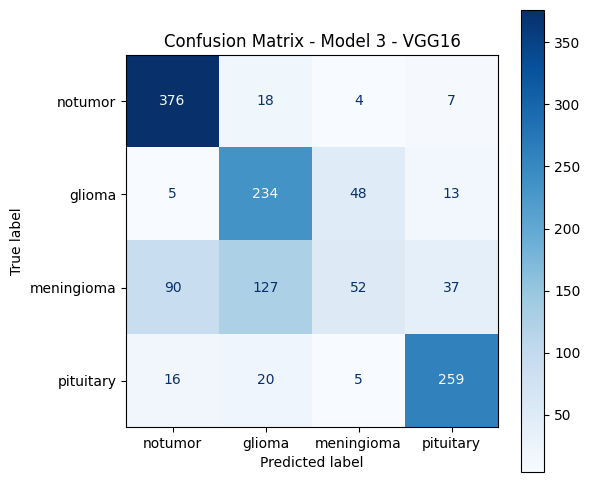

In [140]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix_3.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Model 3 - VGG16')
plt.savefig('/content/drive/MyDrive/graphs/cm_model3.jpeg', dpi = 1080)
plt.show()

In [141]:
(preds_3 == test_data_gen.classes).mean()

0.7025171624713958

In [142]:
# saving VGG16
model_3.save('/content/drive/MyDrive/cnn_models/model3.h5')
model_3.save('/content/drive/MyDrive/cnn_models/model3.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


This model had the worst performance by far. It is possible that the type of images that VGG16 has been trained on are drastically different than those that Xception has been trained on. Despite that, I was very surprised to see it have a much worse score than my own basic CNN model. Another reason could be that VGG16's inherent network topology performs better if images have been preprocessed with different a methodology than the one I employed. Further investigation on this is required from my end to figure out why VGG16 specifically performed so poorly. 

--- 
## Conclusion
The Xception model had the best overall accuracy and it had promising metrics for precision and recall as well. Both of these metrics are as crucial, if not more, than accuracy when it comes to evaluating model performance in the context of the medical field. In the next notebook, I will further evaluate the best model's performance and look further into both precision and recall metrics.